# Capitol One Data Challange 

#### Problem Statement: 
Analyzing 2019 airline data to identify the 10 bussiest and most profitable round-trip routes, recommend 5 routes for investment, calculate their break-even points, and propose KPIs to measure success. 

In [118]:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import FileLink
from typing import Dict, List


#reading all the data sets

airport= pd.read_csv(r'C:\Users\rohit\Desktop\resume\resume v\study\Capitol One\Airport_Codes.csv')
flight = pd.read_csv(r'C:\Users\rohit\Desktop\resume\resume v\study\Capitol One\Flights.csv', 
                           dtype={
                               'FL_DATE': str,  
                               'CANCELLED': int,  
                               'DEP_DELAY': float,
                               'ARR_DELAY': float,
                               'OCCUPANCY_RATE': float
                           },
                           parse_dates=['FL_DATE'],  # Converting to date column
                           low_memory=False)
ticket=  pd.read_csv(r'C:\Users\rohit\Desktop\resume\resume v\study\Capitol One\Tickets.csv')


#### Analysing Airport Dataset

In [119]:
print(airport.head())

            TYPE                                NAME  ELEVATION_FT CONTINENT  \
0       heliport                   Total Rf Heliport          11.0       NaN   
1  small_airport                Aero B Ranch Airport        3435.0       NaN   
2  small_airport                        Lowell Field         450.0       NaN   
3  small_airport                        Epps Airpark         820.0       NaN   
4         closed  Newport Hospital & Clinic Heliport         237.0       NaN   

  ISO_COUNTRY  MUNICIPALITY IATA_CODE                            COORDINATES  
0          US      Bensalem       NaN     -74.93360137939453, 40.07080078125  
1          US         Leoti       NaN                 -101.473911, 38.704022  
2          US  Anchor Point       NaN            -151.695999146, 59.94919968  
3          US       Harvest       NaN  -86.77030181884766, 34.86479949951172  
4          US       Newport       NaN                    -91.254898, 35.6087  


In [120]:
#checking the basic info
print(airport.info())
print(f"\nThe shape of the data is: {airport.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55369 entries, 0 to 55368
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          55369 non-null  object 
 1   NAME          55369 non-null  object 
 2   ELEVATION_FT  48354 non-null  float64
 3   CONTINENT     27526 non-null  object 
 4   ISO_COUNTRY   55122 non-null  object 
 5   MUNICIPALITY  49663 non-null  object 
 6   IATA_CODE     9182 non-null   object 
 7   COORDINATES   55369 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.4+ MB
None

The shape of the data is: (55369, 8)


#### Preprocessing Airport Dataset

In [121]:
#checking for null values before filtering the data set
print(airport.isnull().sum())

TYPE                0
NAME                0
ELEVATION_FT     7015
CONTINENT       27843
ISO_COUNTRY       247
MUNICIPALITY     5706
IATA_CODE       46187
COORDINATES         0
dtype: int64


In [122]:
#Filtering the airport data that only has medium_large ariports 
airport_filter = airport[
    (airport['TYPE'].isin(['medium_airport', 'large_airport'])) &
    (airport['ISO_COUNTRY']== 'US')]
print(airport_filter.info())

#Getting only required columns
airport_data = airport_filter[['TYPE', 'IATA_CODE']]

print(f"\nThe shape of the data is: {airport_data.shape}")

# Display the filtered dataset
print(airport_data.head())




<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 6194 to 50008
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          858 non-null    object 
 1   NAME          858 non-null    object 
 2   ELEVATION_FT  855 non-null    float64
 3   CONTINENT     0 non-null      object 
 4   ISO_COUNTRY   858 non-null    object 
 5   MUNICIPALITY  855 non-null    object 
 6   IATA_CODE     821 non-null    object 
 7   COORDINATES   858 non-null    object 
dtypes: float64(1), object(7)
memory usage: 60.3+ KB
None

The shape of the data is: (858, 2)
                 TYPE IATA_CODE
6194   medium_airport       WKK
25963  medium_airport       NaN
26143  medium_airport       ABE
26144  medium_airport       ABI
26145   large_airport       ABQ


In [123]:
# Checking for duplicates 
print("The number of duplicates are", airport_data.duplicated().sum())

#checking for null values after filtering the data set
print("\nMissing Values", airport_data.isnull().sum())
print(f"\nData shape before removing missing values: {airport_data.shape}")



The number of duplicates are 35

Missing Values TYPE          0
IATA_CODE    37
dtype: int64

Data shape before removing missing values: (858, 2)


In [124]:

#dropping the null values 
airport_final = airport_data[airport_data['IATA_CODE'].notna()]
print(airport_final.isnull().sum())


print(f"\nData shape after removing missing values: {airport_data.shape}")

print(airport_final.info())

TYPE         0
IATA_CODE    0
dtype: int64

Data shape after removing missing values: (858, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 821 entries, 6194 to 39286
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TYPE       821 non-null    object
 1   IATA_CODE  821 non-null    object
dtypes: object(2)
memory usage: 19.2+ KB
None


#### Analysing Tickets Dataset


In [125]:
print(ticket.head())

        ITIN_ID  YEAR  QUARTER ORIGIN ORIGIN_COUNTRY ORIGIN_STATE_ABR  \
0  201912723049  2019        1    ABI             US               TX   
1  201912723085  2019        1    ABI             US               TX   
2  201912723491  2019        1    ABI             US               TX   
3  201912723428  2019        1    ABI             US               TX   
4  201912723509  2019        1    ABI             US               TX   

  ORIGIN_STATE_NM  ROUNDTRIP REPORTING_CARRIER  PASSENGERS ITIN_FARE  \
0           Texas        1.0                MQ         1.0     736.0   
1           Texas        1.0                MQ         1.0     570.0   
2           Texas        1.0                MQ         1.0     564.0   
3           Texas        1.0                MQ         1.0     345.0   
4           Texas        0.0                MQ         1.0     309.0   

  DESTINATION  
0         DAB  
1         COS  
2         MCO  
3         LGA  
4         MGM  


In [126]:
#checking the basic info
print(ticket.info())
print(f"\nThe shape of the data is: {ticket.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167285 entries, 0 to 1167284
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   ITIN_ID            1167285 non-null  int64  
 1   YEAR               1167285 non-null  int64  
 2   QUARTER            1167285 non-null  int64  
 3   ORIGIN             1167285 non-null  object 
 4   ORIGIN_COUNTRY     1167285 non-null  object 
 5   ORIGIN_STATE_ABR   1167285 non-null  object 
 6   ORIGIN_STATE_NM    1167285 non-null  object 
 7   ROUNDTRIP          1167285 non-null  float64
 8   REPORTING_CARRIER  1167285 non-null  object 
 9   PASSENGERS         1165308 non-null  float64
 10  ITIN_FARE          1166325 non-null  object 
 11  DESTINATION        1167285 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 106.9+ MB
None

The shape of the data is: (1167285, 12)


#### Preprocessing Ticket Dataset


In [127]:
# Convert ITIN_FARE to numeric, coerce errors to NaN
ticket['ITIN_FARE'] = pd.to_numeric(ticket['ITIN_FARE'], errors='coerce')

#filtering the data for only round trips
ticket_data = ticket[(ticket['ROUNDTRIP'] == 1) & (ticket['ITIN_FARE'] > 50)][['ORIGIN_STATE_ABR','ORIGIN', 'DESTINATION', 'ITIN_FARE', 'PASSENGERS']]
print(ticket_data.head(10))
print("\n the shape is",ticket_data.shape)



   ORIGIN_STATE_ABR ORIGIN DESTINATION  ITIN_FARE  PASSENGERS
0                TX    ABI         DAB      736.0         1.0
1                TX    ABI         COS      570.0         1.0
2                TX    ABI         MCO      564.0         1.0
3                TX    ABI         LGA      345.0         1.0
10               TX    ABI         JAX     1647.0         1.0
11               TX    ABI         LIT      425.0         1.0
12               TX    ABI         FAI     1445.0         1.0
13               TX    ABI         BNA      842.0         1.0
14               TX    ABI         RDU      279.0         1.0
15               TX    ABI         CLE      379.0         1.0

 the shape is (666090, 5)


In [128]:
#Checking for null values after filtering the data
print(ticket_data.isnull().sum())



ORIGIN_STATE_ABR       0
ORIGIN                 0
DESTINATION            0
ITIN_FARE              0
PASSENGERS          1136
dtype: int64


In [129]:
ticket_data.dropna(subset=['PASSENGERS'], inplace=True)
print(ticket_data.isnull().sum())


ORIGIN_STATE_ABR    0
ORIGIN              0
DESTINATION         0
ITIN_FARE           0
PASSENGERS          0
dtype: int64


In [130]:
#checking for duplicates
print("The number of duplicate values", ticket_data.duplicated().sum())



The number of duplicate values 75168


In [131]:
#Checking duplicates by rows
duplicate_counts = {}
for column in ticket_data.columns:
    duplicates = ticket_data[column].duplicated().sum()
    if duplicates > 0:
        duplicate_counts[column] = duplicates

print("Number of duplicates in each column:")
for column, count in duplicate_counts.items():
    print(f"{column}: {count} duplicates")

Number of duplicates in each column:
ORIGIN_STATE_ABR: 664902 duplicates
ORIGIN: 664545 duplicates
DESTINATION: 664562 duplicates
ITIN_FARE: 661419 duplicates
PASSENGERS: 664789 duplicates


In [132]:
#Aggregating columns to get Passenger count and Avg fare
agg_ticket = ticket_data.groupby(['ORIGIN', 'DESTINATION']).agg({
   'PASSENGERS': ['sum', 'count'],
    'ITIN_FARE': ['mean'],
}).reset_index()

#  rename columns
agg_ticket.columns = ['ORIGIN', 'DESTINATION', 'PASSENGER_CNT', 'TICKET_CNT', 'ITIN_FARE_AVG']

# Rounding 'ITIN_Fare_avg' column to 2 decimal places
agg_ticket['ITIN_FARE_AVG'] = agg_ticket['ITIN_FARE_AVG'].round(2)


print(agg_ticket.info())
print(agg_ticket.head())
print(print("\n The shape is",agg_ticket.shape))




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39518 entries, 0 to 39517
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ORIGIN         39518 non-null  object 
 1   DESTINATION    39518 non-null  object 
 2   PASSENGER_CNT  39518 non-null  float64
 3   TICKET_CNT     39518 non-null  int64  
 4   ITIN_FARE_AVG  39518 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.5+ MB
None
  ORIGIN DESTINATION  PASSENGER_CNT  TICKET_CNT  ITIN_FARE_AVG
0    ABE         ABQ            2.0           2         534.00
1    ABE         AGS            1.0           1         299.00
2    ABE         AMA            1.0           1         654.00
3    ABE         ASE            2.0           2         742.00
4    ABE         ATL           55.0          50         524.46

 The shape is (39518, 5)
None


In [133]:
#calculating IQR values
Q1 = agg_ticket['ITIN_FARE_AVG'].quantile(0.25)
Q3 = agg_ticket['ITIN_FARE_AVG'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = 2500



ticket_final = agg_ticket.copy()
ticket_final['ITIN_FARE_AVG'] = ticket_final['ITIN_FARE_AVG'].clip(lower=lower_bound, upper=upper_bound)


print("\nOriginal Data Statistics")
print(agg_ticket['ITIN_FARE_AVG'].describe())
print("\nCapped Data Statistics:")
print(ticket_final['ITIN_FARE_AVG'].describe())


print(f"\nThe Final Shape is:", ticket_final.shape) 



Original Data Statistics
count    39518.000000
mean       577.856133
std        276.972014
min         54.000000
25%        425.000000
50%        524.000000
75%        656.280000
max       9794.750000
Name: ITIN_FARE_AVG, dtype: float64

Capped Data Statistics:
count    39518.000000
mean       576.408078
std        259.959150
min         78.080000
25%        425.000000
50%        524.000000
75%        656.280000
max       2500.000000
Name: ITIN_FARE_AVG, dtype: float64

The Final Shape is: (39518, 5)


In [134]:
#ticket_final.to_csv('ticket_final.csv', index=False)
#file_path = 'ticket_final.csv'
#FileLink(file_path)

#### Analyzing Flights Dataset

In [135]:
print(flight.head())

     FL_DATE OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID ORIGIN  \
0 2019-03-02         WN   N955WN              4591              14635    RSW   
1 2019-03-02         WN   N8686A              3231              14635    RSW   
2 2019-03-02         WN   N201LV              3383              14635    RSW   
3 2019-03-02         WN   N413WN              5498              14635    RSW   
4 2019-03-02         WN   N7832A              6933              14635    RSW   

  ORIGIN_CITY_NAME  DEST_AIRPORT_ID DESTINATION DEST_CITY_NAME  DEP_DELAY  \
0   Fort Myers, FL            11042         CLE  Cleveland, OH       -8.0   
1   Fort Myers, FL            11066         CMH   Columbus, OH        1.0   
2   Fort Myers, FL            11066         CMH   Columbus, OH        0.0   
3   Fort Myers, FL            11066         CMH   Columbus, OH       11.0   
4   Fort Myers, FL            11259         DAL     Dallas, TX        0.0   

   ARR_DELAY  CANCELLED AIR_TIME DISTANCE  OCCUPANCY_RAT

In [136]:
#checking the basic info
print(flight.info())
print(f"\nThe shape of the data is: {flight.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915886 entries, 0 to 1915885
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   FL_DATE            datetime64[ns]
 1   OP_CARRIER         object        
 2   TAIL_NUM           object        
 3   OP_CARRIER_FL_NUM  object        
 4   ORIGIN_AIRPORT_ID  int64         
 5   ORIGIN             object        
 6   ORIGIN_CITY_NAME   object        
 7   DEST_AIRPORT_ID    int64         
 8   DESTINATION        object        
 9   DEST_CITY_NAME     object        
 10  DEP_DELAY          float64       
 11  ARR_DELAY          float64       
 12  CANCELLED          int32         
 13  AIR_TIME           object        
 14  DISTANCE           object        
 15  OCCUPANCY_RATE     float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(9)
memory usage: 226.6+ MB
None

The shape of the data is: (1915886, 16)


#### Preprocessing Flight Dataset

In [137]:
#filtering the data for no cancelled trips
flight_data = flight[(flight['CANCELLED'] == 0)][['FL_DATE','ORIGIN', 'DESTINATION', 'DEP_DELAY', 'ARR_DELAY','AIR_TIME','DISTANCE','OCCUPANCY_RATE']]
print(flight_data.head(10))

     FL_DATE ORIGIN DESTINATION  DEP_DELAY  ARR_DELAY AIR_TIME DISTANCE  \
0 2019-03-02    RSW         CLE       -8.0       -6.0    143.0   1025.0   
1 2019-03-02    RSW         CMH        1.0        5.0    135.0    930.0   
2 2019-03-02    RSW         CMH        0.0        4.0    132.0    930.0   
3 2019-03-02    RSW         CMH       11.0       14.0    136.0    930.0   
4 2019-03-02    RSW         DAL        0.0      -17.0    151.0   1005.0   
5 2019-03-02    RSW         GRR       -2.0       -8.0    162.0   1147.0   
6 2019-03-02    RSW         IND       11.0       17.0    143.0    945.0   
7 2019-03-02    RSW         IND       -5.0        8.0    139.0    945.0   
8 2019-03-02    RSW         IND       -9.0      -16.0    135.0    945.0   
9 2019-03-02    RSW         IND        0.0       11.0    150.0    945.0   

   OCCUPANCY_RATE  
0            0.97  
1            0.55  
2            0.91  
3            0.67  
4            0.62  
5            0.49  
6            0.49  
7            0

In [138]:
#checking the basic info
print(flight_data.info())
print(f"\nThe shape of the data is: {flight_data.shape}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1864272 entries, 0 to 1915885
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   FL_DATE         datetime64[ns]
 1   ORIGIN          object        
 2   DESTINATION     object        
 3   DEP_DELAY       float64       
 4   ARR_DELAY       float64       
 5   AIR_TIME        object        
 6   DISTANCE        object        
 7   OCCUPANCY_RATE  float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 128.0+ MB
None

The shape of the data is: (1864272, 8)


In [139]:
#Checking for null values after filtering the data
print(flight_data.isnull().sum())

FL_DATE              0
ORIGIN               0
DESTINATION          0
DEP_DELAY            0
ARR_DELAY         4377
AIR_TIME          5027
DISTANCE           610
OCCUPANCY_RATE     310
dtype: int64


In [140]:
#Deleting null values
flight_data.dropna(subset=['ARR_DELAY','AIR_TIME','DISTANCE','OCCUPANCY_RATE'], inplace=True)

print(flight_data.isnull().sum())

FL_DATE           0
ORIGIN            0
DESTINATION       0
DEP_DELAY         0
ARR_DELAY         0
AIR_TIME          0
DISTANCE          0
OCCUPANCY_RATE    0
dtype: int64


In [141]:
#checking for duplicates
print(f"\nThe number of duplicate values", flight_data.duplicated().sum())


# Check duplicates by route and date
dup_by_flight = flight_data.duplicated(
    subset=['FL_DATE', 'ORIGIN', 'DESTINATION']
).sum()
print(f"\nDuplicates by route and date: {dup_by_flight}")




The number of duplicate values 3248

Duplicates by route and date: 1406957


In [142]:
agg_flight = flight_data.groupby(
   ['FL_DATE', 'ORIGIN', 'DESTINATION']
).agg({
   'DEP_DELAY': 'mean',
   'ARR_DELAY': 'mean',
   'DISTANCE': 'first',
   'OCCUPANCY_RATE': 'mean'
}).reset_index()

#  rename columns
agg_flight.columns = ['FL_DATE', 'ORIGIN', 'DESTINATION', 'AVG_DEP_DELAY', 'AVG_ARR_DELAY','DISTANCE','OCCUPANCY_RATE']


#Rounding 'AVG_ARR_DELAY' & 'AVG_DEP_DELAY' column to 2 decimal places
agg_flight['AVG_ARR_DELAY'] = agg_flight['AVG_ARR_DELAY'].round(1)
agg_flight['AVG_DEP_DELAY'] = agg_flight['AVG_DEP_DELAY'].round(1)

#Converting occupancy rate to percentage
agg_flight['OCCUPANCY_RATE'] = agg_flight['OCCUPANCY_RATE'].round(2)*100

print(agg_flight.head(10))
print(agg_flight.info())
print(print("\n The shape is",agg_flight.shape))


     FL_DATE ORIGIN DESTINATION  AVG_DEP_DELAY  AVG_ARR_DELAY DISTANCE  \
0 2019-01-01    ABE         ATL           -3.0           -9.0    692.0   
1 2019-01-01    ABE         CLT           -9.0           -9.3    481.0   
2 2019-01-01    ABE         DTW           -3.5          -16.5    425.0   
3 2019-01-01    ABE         ORD            5.5           17.5    654.0   
4 2019-01-01    ABE         PHL           -6.0          -10.0     55.0   
5 2019-01-01    ABE         PIE          -22.0          -30.0    970.0   
6 2019-01-01    ABE         SFB           -5.0           -4.0    882.0   
7 2019-01-01    ABI         DFW            3.2            9.2    158.0   
8 2019-01-01    ABQ         ATL           -3.5           -9.0   1269.0   
9 2019-01-01    ABQ         BWI           -2.0          -20.0   1670.0   

   OCCUPANCY_RATE  
0            56.0  
1            85.0  
2            65.0  
3            71.0  
4            97.0  
5            54.0  
6            79.0  
7            58.0  
8    

In [143]:
#Analyzing ouliers and handelling them for distance column
agg_flight['DISTANCE'] = pd.to_numeric(agg_flight['DISTANCE'], errors='coerce')

# First, calculate IQR values
Q1 = agg_flight['DISTANCE'].quantile(0.25)
Q3 = agg_flight['DISTANCE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR 
 
outliers = agg_flight['DISTANCE'].clip(lower=lower_bound, upper=upper_bound)

#Capping the data
flight_final = agg_flight.copy()
flight_final['DISTANCE'] = flight_final['DISTANCE'].clip(lower=200, upper=4000)


print("\nOutliers:")
print(outliers.describe())
print("\nCapped Distance:")
print(flight_final['DISTANCE'].describe())






Outliers:
count    451638.000000
mean        839.542587
std         561.413145
min           2.000000
25%         405.000000
50%         712.000000
75%        1113.000000
max        2175.000000
Name: DISTANCE, dtype: float64

Capped Distance:
count    451638.000000
mean        867.983790
std         626.103998
min         200.000000
25%         405.000000
50%         712.000000
75%        1113.000000
max        4000.000000
Name: DISTANCE, dtype: float64


In [144]:
#flight_final.to_csv('flight_final.csv', index=False)
#file_path = 'flight_final.csv'
#FileLink(file_path)

#### Merging Datasets

In [145]:
def join_airline_datasets(airport_final, ticket_final, flight_final, join_type='inner'):
    
    # Standardizing column names
    airport_final.columns = [col.strip().upper() for col in airport_final.columns]
    ticket_final.columns = [col.strip().upper() for col in ticket_final.columns]
    flight_final.columns = [col.strip().upper() for col in flight_final.columns]
    
    
    # First joining tickets and flights
    merged_df = pd.merge(
        ticket_final, 
        flight_final, 
        on=['ORIGIN', 'DESTINATION'], 
        how=join_type
    )
    
    # Dropping rows with invalid airports
    airport_final = airport_final.dropna(subset=['IATA_CODE'])
    
    # Joining with origin airports
    merged_df = pd.merge(
        merged_df,
        airport_final,
        left_on='ORIGIN',
        right_on='IATA_CODE',
        how=join_type
    )
    
    # Joining with destination airports
    final_merged = pd.merge(
        merged_df,
        airport_final,
        left_on='DESTINATION',
        right_on='IATA_CODE',
        how=join_type,
        suffixes=('_ORIGIN', '_DESTINATION')
    )
    
   
    print(f"Final merged shape: {final_merged.shape}")
    print("\nColumns in final dataset:")
    print(final_merged.columns.tolist())
    
    return final_merged

final_merged = join_airline_datasets(airport_final, ticket_final, flight_final)

print(final_merged.info())


Final merged shape: (428379, 14)

Columns in final dataset:
['ORIGIN', 'DESTINATION', 'PASSENGER_CNT', 'TICKET_CNT', 'ITIN_FARE_AVG', 'FL_DATE', 'AVG_DEP_DELAY', 'AVG_ARR_DELAY', 'DISTANCE', 'OCCUPANCY_RATE', 'TYPE_ORIGIN', 'IATA_CODE_ORIGIN', 'TYPE_DESTINATION', 'IATA_CODE_DESTINATION']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 428379 entries, 0 to 428378
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ORIGIN                 428379 non-null  object        
 1   DESTINATION            428379 non-null  object        
 2   PASSENGER_CNT          428379 non-null  float64       
 3   TICKET_CNT             428379 non-null  int64         
 4   ITIN_FARE_AVG          428379 non-null  float64       
 5   FL_DATE                428379 non-null  datetime64[ns]
 6   AVG_DEP_DELAY          428379 non-null  float64       
 7   AVG_ARR_DELAY          428379 non-null  float64       


In [146]:
final_merged.head(10)
print(final_merged.isnull().sum())

ORIGIN                   0
DESTINATION              0
PASSENGER_CNT            0
TICKET_CNT               0
ITIN_FARE_AVG            0
FL_DATE                  0
AVG_DEP_DELAY            0
AVG_ARR_DELAY            0
DISTANCE                 0
OCCUPANCY_RATE           0
TYPE_ORIGIN              0
IATA_CODE_ORIGIN         0
TYPE_DESTINATION         0
IATA_CODE_DESTINATION    0
dtype: int64


In [147]:
final_merged=final_merged[['FL_DATE','TYPE_ORIGIN','ORIGIN','DESTINATION','DISTANCE','OCCUPANCY_RATE','ITIN_FARE_AVG','TICKET_CNT','PASSENGER_CNT',
                           'AVG_DEP_DELAY','AVG_ARR_DELAY']]
final_merged.head(10)

,FL_DATE,TYPE_ORIGIN,ORIGIN,DESTINATION,DISTANCE,OCCUPANCY_RATE,ITIN_FARE_AVG,TICKET_CNT,PASSENGER_CNT,AVG_DEP_DELAY,AVG_ARR_DELAY
0,2019-01-01,medium_airport,ABE,ATL,692.0,56.0,524.46,50,55.0,-3.0,-9.0
1,2019-01-02,medium_airport,ABE,ATL,692.0,71.0,524.46,50,55.0,-4.0,-2.0
2,2019-01-03,medium_airport,ABE,ATL,692.0,50.0,524.46,50,55.0,0.5,-12.0
3,2019-01-04,medium_airport,ABE,ATL,692.0,80.0,524.46,50,55.0,-5.0,-15.5
4,2019-01-05,medium_airport,ABE,ATL,692.0,46.0,524.46,50,55.0,0.0,-7.0
5,2019-01-06,medium_airport,ABE,ATL,692.0,39.0,524.46,50,55.0,6.5,-19.5
6,2019-01-07,medium_airport,ABE,ATL,692.0,53.0,524.46,50,55.0,9.0,4.0
7,2019-01-08,medium_airport,ABE,ATL,692.0,65.0,524.46,50,55.0,-4.5,6.5
8,2019-01-09,medium_airport,ABE,ATL,692.0,72.0,524.46,50,55.0,-1.5,-21.5
9,2019-01-10,medium_airport,ABE,ATL,692.0,52.0,524.46,50,55.0,-1.0,-24.0


In [148]:
#final_merged.to_csv('Airline_merged.csv', index=False)
#file_path = 'Airline_merged.csv'
#FileLink(file_path)

#### Introducing new Coulmns

In [149]:
# Creating  roundtrip identifier and Count of flights per round trips by sorting origin and destination on date
final_merged['FLIGHTS_PER_ROUTE'] = final_merged.groupby(['ORIGIN', 'DESTINATION'])['FL_DATE'].transform('count')
final_merged['ROUNDTRIP'] = final_merged.apply(lambda x: '-'.join(sorted([x['ORIGIN'], x['DESTINATION']])), axis=1)
final_merged['FLIGHTS_ROUNDTRIP'] = final_merged.groupby(['ROUNDTRIP'])['FL_DATE'].transform('count')
final_merged['TRIPS_PER_DAY'] = final_merged['FLIGHTS_ROUNDTRIP']/final_merged['FLIGHTS_PER_ROUTE']
# Extracting Month 
final_merged['MONTH'] = pd.to_datetime(final_merged['FL_DATE']).dt.strftime('%b')

print(final_merged.head())
print(final_merged.info())



     FL_DATE     TYPE_ORIGIN ORIGIN DESTINATION  DISTANCE  OCCUPANCY_RATE  \
0 2019-01-01  medium_airport    ABE         ATL     692.0            56.0   
1 2019-01-02  medium_airport    ABE         ATL     692.0            71.0   
2 2019-01-03  medium_airport    ABE         ATL     692.0            50.0   
3 2019-01-04  medium_airport    ABE         ATL     692.0            80.0   
4 2019-01-05  medium_airport    ABE         ATL     692.0            46.0   

   ITIN_FARE_AVG  TICKET_CNT  PASSENGER_CNT  AVG_DEP_DELAY  AVG_ARR_DELAY  \
0         524.46          50           55.0           -3.0           -9.0   
1         524.46          50           55.0           -4.0           -2.0   
2         524.46          50           55.0            0.5          -12.0   
3         524.46          50           55.0           -5.0          -15.5   
4         524.46          50           55.0            0.0           -7.0   

   FLIGHTS_PER_ROUTE ROUNDTRIP  FLIGHTS_ROUNDTRIP  TRIPS_PER_DAY MONTH  
0

In [150]:
# Creating new columnsfor Arrival and Delay columns for better analysis

def categorize_delay(delay):
    if delay < 0:
        return 'Early'
    elif delay <= 15:
        return 'On Time'
    elif delay <= 45:
        return 'Minor Delay'
    else:
        return 'Major Delay'

final_merged['DEP_DELAY_CATEGORY'] = final_merged['AVG_DEP_DELAY'].apply(categorize_delay)
final_merged['ARR_DELAY_CATEGORY'] = final_merged['AVG_ARR_DELAY'].apply(categorize_delay)

print(final_merged.head())
print(final_merged.info())

     FL_DATE     TYPE_ORIGIN ORIGIN DESTINATION  DISTANCE  OCCUPANCY_RATE  \
0 2019-01-01  medium_airport    ABE         ATL     692.0            56.0   
1 2019-01-02  medium_airport    ABE         ATL     692.0            71.0   
2 2019-01-03  medium_airport    ABE         ATL     692.0            50.0   
3 2019-01-04  medium_airport    ABE         ATL     692.0            80.0   
4 2019-01-05  medium_airport    ABE         ATL     692.0            46.0   

   ITIN_FARE_AVG  TICKET_CNT  PASSENGER_CNT  AVG_DEP_DELAY  AVG_ARR_DELAY  \
0         524.46          50           55.0           -3.0           -9.0   
1         524.46          50           55.0           -4.0           -2.0   
2         524.46          50           55.0            0.5          -12.0   
3         524.46          50           55.0           -5.0          -15.5   
4         524.46          50           55.0            0.0           -7.0   

   FLIGHTS_PER_ROUTE ROUNDTRIP  FLIGHTS_ROUNDTRIP  TRIPS_PER_DAY MONTH  \


In [151]:
airline_data = final_merged[['FL_DATE','MONTH','TYPE_ORIGIN','ORIGIN','DESTINATION','ROUNDTRIP','FLIGHTS_PER_ROUTE','FLIGHTS_ROUNDTRIP','TRIPS_PER_DAY','DISTANCE','OCCUPANCY_RATE','ITIN_FARE_AVG','TICKET_CNT','PASSENGER_CNT',
                            'AVG_DEP_DELAY','DEP_DELAY_CATEGORY','AVG_ARR_DELAY','ARR_DELAY_CATEGORY']]

airline_data.head()
#airline_data.to_csv('airline_data.csv', index=False)
#file_path = 'airline_data.csv'
#FileLink(file_path)





,FL_DATE,MONTH,TYPE_ORIGIN,ORIGIN,DESTINATION,ROUNDTRIP,FLIGHTS_PER_ROUTE,FLIGHTS_ROUNDTRIP,TRIPS_PER_DAY,DISTANCE,OCCUPANCY_RATE,ITIN_FARE_AVG,TICKET_CNT,PASSENGER_CNT,AVG_DEP_DELAY,DEP_DELAY_CATEGORY,AVG_ARR_DELAY,ARR_DELAY_CATEGORY
0,2019-01-01,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,56.0,524.46,50,55.0,-3.0,Early,-9.0,Early
1,2019-01-02,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,71.0,524.46,50,55.0,-4.0,Early,-2.0,Early
2,2019-01-03,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,50.0,524.46,50,55.0,0.5,On Time,-12.0,Early
3,2019-01-04,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,80.0,524.46,50,55.0,-5.0,Early,-15.5,Early
4,2019-01-05,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,46.0,524.46,50,55.0,0.0,On Time,-7.0,Early


### Exploratory Data Analysis

### Top 10 Busiest Round Trip Routes 

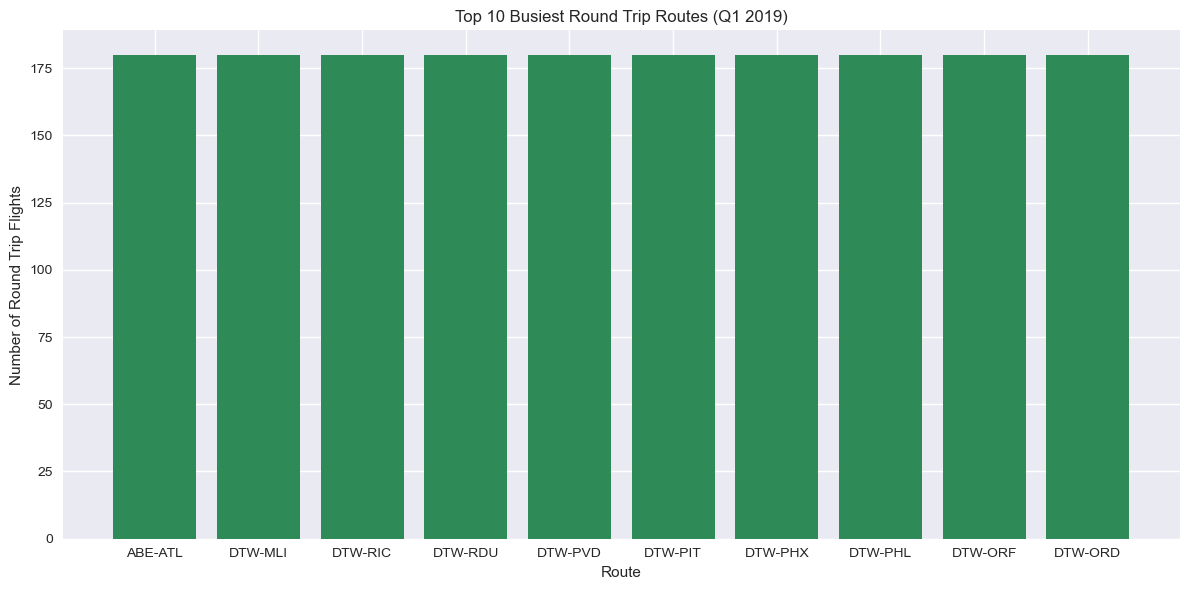

,ROUNDTRIP,FLIGHTS_ROUNDTRIP,TRIPS_PER_DAY,DISTANCE,OCCUPANCY_RATE
0,ABE-ATL,180,2.0,692.0,65.222222
1426,DTW-MLI,180,2.0,373.0,64.788889
1445,DTW-RIC,180,2.0,456.0,65.344444
1444,DTW-RDU,180,2.0,501.0,64.527778
1442,DTW-PVD,180,2.0,615.0,65.300000
1440,DTW-PIT,180,2.0,201.0,65.372222
1439,DTW-PHX,180,2.0,1671.0,63.883333
1438,DTW-PHL,180,2.0,453.0,64.222222
1435,DTW-ORF,180,2.0,529.0,64.750000
1434,DTW-ORD,180,2.0,235.0,65.277778


In [152]:
def analyze_busiest_routes(airline_data):
    # Group by route and calculate total round trips
    route_summary = airline_data.groupby('ROUNDTRIP').agg({
        'FLIGHTS_ROUNDTRIP': 'first',  
        'TRIPS_PER_DAY': 'first',      
        'DISTANCE': 'first',           
        'OCCUPANCY_RATE': 'mean'       
    }).reset_index()
    

    busiest_routes = route_summary.sort_values('FLIGHTS_ROUNDTRIP', ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    plt.bar(busiest_routes['ROUNDTRIP'], busiest_routes['FLIGHTS_ROUNDTRIP'],color='seagreen')
    plt.title('Top 10 Busiest Round Trip Routes (Q1 2019)')
    plt.xlabel('Route')
    plt.ylabel('Number of Round Trip Flights')
    
    plt.tight_layout()
    plt.show()

    
    return busiest_routes
analyze_busiest_routes(airline_data)


### Top 10 Profitable Roundtrip Routes

#### Assumptions

In [153]:

# Per flight revenue = (Occupancy_Rate/100 * 200 seats * Average_Fare) 
# + (Baggage fees: 50% passengers * $70 per roundtrip)
# Per mile costs:
# Fuel, Oil, Maintenance, Crew: $8/mile
#Depreciation, Insurance, Other: $1.18/mile

# Airport fees per round trip:
# Medium airport: $5,000 per landing
# Large airport: $10,000 per landing

# Delay costs:
# After 15 minutes: $75/minute for departures
# After 15 minutes: $75/minute for arrivals
    

C:\Users\rohit\AppData\Local\Temp\ipykernel_72744\548760490.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airline_data['PASSENGER_REVENUE'] = (airline_data['OCCUPANCY_RATE']/100) * 200 * airline_data['ITIN_FARE_AVG']
C:\Users\rohit\AppData\Local\Temp\ipykernel_72744\548760490.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airline_data['BAGGAGE_REVENUE'] = (airline_data['OCCUPANCY_RATE']/100) * 200 * 0.5 * 70
C:\Users\rohit\AppData\Local\Temp\ipykernel_72744\548760490.py:6: SettingWithCopyWarning:

Step 1: Profitability Calculations
  ROUNDTRIP  TOTAL_REVENUE  TOTAL_COST    PROFIT
0   ABE-ATL       62659.52    16352.56  46306.96
1   ABE-ATL       79443.32    16352.56  63090.76
2   ABE-ATL       55946.00    16352.56  39593.44
3   ABE-ATL       89513.60    16352.56  73161.04
4   ABE-ATL       51470.32    16352.56  35117.76

Step 2: Top Profitable Routes
     ROUNDTRIP  TOTAL_REVENUE  TOTAL_COST       PROFIT  FLIGHTS_ROUNDTRIP  \
2780   SLC-TWF    34944838.46  2268390.00  32676448.46                180   
826    CLT-FLO    23561856.00  1133160.00  22428696.00                 90   
1516   EWR-HNL    29535790.68  8662510.00  20873280.68                178   
1559   EWR-SFO    27097114.38  6343288.50  20753825.88                180   
167    ATL-HNL    29222053.70  8563500.00  20658553.70                180   
1476   EGE-JFK    24072100.18  3662196.88  20409903.30                121   
1736   HNL-IAH    27799946.22  8247042.16  19552904.06                178   
2656   PIH-SLC    206126

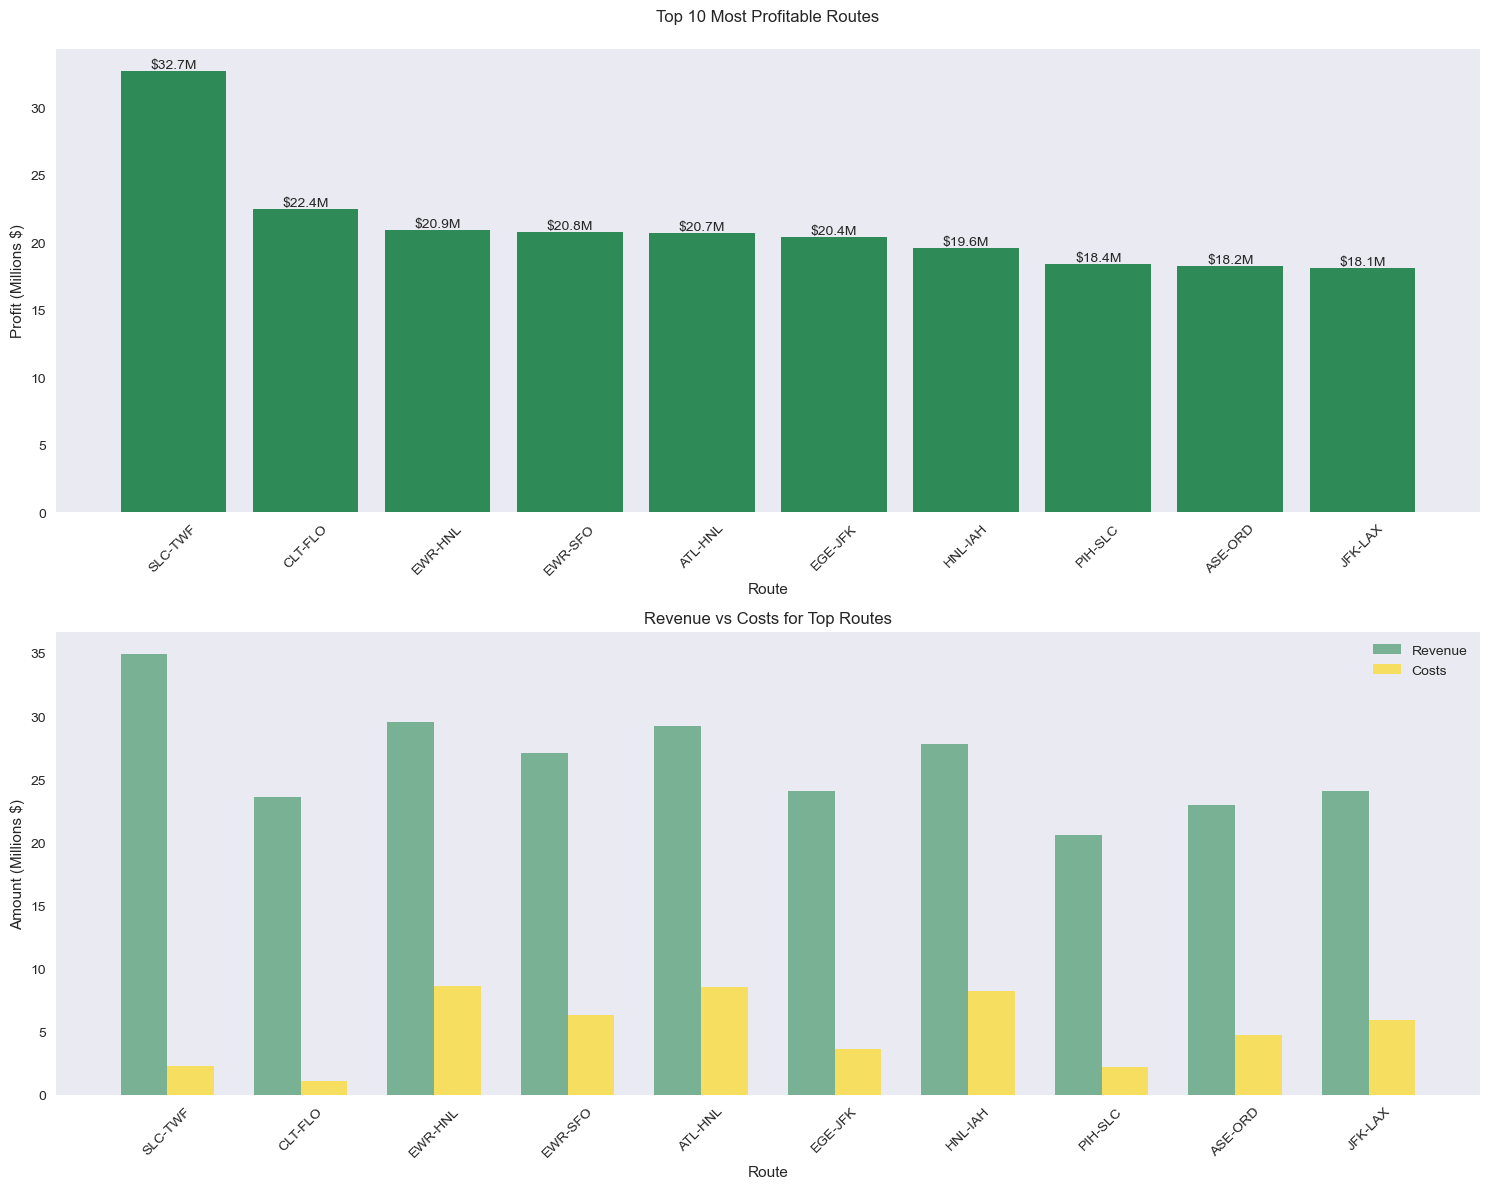


Step 4: Detailed Analysis

Detailed Analysis of Top 10 Most Profitable Routes:

Route 2781: SLC-TWF
Total Profit: $32,676,448.46
Total Revenue: $34,944,838.46
Total Costs: $2,268,390.00
Number of Round Trip Flights: 180
Average Occupancy Rate: 66.8%
Distance: 200.0 miles
----------------------------------------

Route 827: CLT-FLO
Total Profit: $22,428,696.00
Total Revenue: $23,561,856.00
Total Costs: $1,133,160.00
Number of Round Trip Flights: 90
Average Occupancy Rate: 64.4%
Distance: 200.0 miles
----------------------------------------

Route 1517: EWR-HNL
Total Profit: $20,873,280.68
Total Revenue: $29,535,790.68
Total Costs: $8,662,510.00
Number of Round Trip Flights: 178
Average Occupancy Rate: 64.2%
Distance: 4000.0 miles
----------------------------------------

Route 1560: EWR-SFO
Total Profit: $20,753,825.88
Total Revenue: $27,097,114.38
Total Costs: $6,343,288.50
Number of Round Trip Flights: 180
Average Occupancy Rate: 65.0%
Distance: 2565.0 miles
-------------------------

In [154]:
# Calculating revenue and costs
def calculate_profitability(airline_data):
    
    airline_data['PASSENGER_REVENUE'] = (airline_data['OCCUPANCY_RATE']/100) * 200 * airline_data['ITIN_FARE_AVG']
    airline_data['BAGGAGE_REVENUE'] = (airline_data['OCCUPANCY_RATE']/100) * 200 * 0.5 * 70
    airline_data['TOTAL_REVENUE'] = airline_data['PASSENGER_REVENUE'] + airline_data['BAGGAGE_REVENUE']
    
    airline_data['MILE_COSTS'] = airline_data['DISTANCE'] * (8 + 1.18)  
    
    airline_data['AIRPORT_FEES'] = airline_data.apply(lambda x: 10000 if 'large_airport' in x['ROUNDTRIP'] else 5000, axis=1) * 2
    
    def calculate_delay_cost(delay):
        return max(0, delay - 15) * 75 if delay > 0 else 0
    
    airline_data['DELAY_COST'] = airline_data.apply(lambda x: calculate_delay_cost(x['AVG_DEP_DELAY']) + 
                                         calculate_delay_cost(x['AVG_ARR_DELAY']), axis=1)
    
    airline_data['TOTAL_COST'] = airline_data['MILE_COSTS'] + airline_data['AIRPORT_FEES'] + airline_data['DELAY_COST']
    airline_data['PROFIT'] = airline_data['TOTAL_REVENUE'] - airline_data['TOTAL_COST']
    
    return airline_data

# Analyzing route profitability
def get_top_profitable_routes(airline_data):
    route_profits = airline_data.groupby('ROUNDTRIP').agg({
        'TOTAL_REVENUE': 'sum',
        'TOTAL_COST': 'sum',
        'PROFIT': 'sum',
        'FLIGHTS_ROUNDTRIP': 'first',
        'OCCUPANCY_RATE': 'mean',
        'DISTANCE': 'first'
    }).reset_index()
    
    return route_profits.sort_values('PROFIT', ascending=False).head(10)


def plot_profitability_analysis(top_routes):
    
    plt.style.use('seaborn')
    
    # Creating figure and axes for multiple plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12),facecolor='white')
    
    # Plot 1: Total Profit by Route
    bars = ax1.bar(top_routes['ROUNDTRIP'], top_routes['PROFIT'] / 1000000, color='seagreen')
    ax1.set_title('Top 10 Most Profitable Routes', pad=20)
    ax1.set_xlabel('Route')
    ax1.set_ylabel('Profit (Millions $)')
    ax1.tick_params(axis='x', rotation=45)
    
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.1f}M',
                ha='center', va='bottom')
    
    # Plot 2: Revenue vs Costs
    width = 0.35
    x = range(len(top_routes))
    ax2.bar([i - width/2 for i in x], top_routes['TOTAL_REVENUE'] / 1000000, 
            width, label='Revenue', color='seagreen', alpha=0.6)
    ax2.bar([i + width/2 for i in x], top_routes['TOTAL_COST'] / 1000000, 
            width, label='Costs', color='gold', alpha=0.6)
    
    ax2.set_title('Revenue vs Costs for Top Routes')
    ax2.set_xlabel('Route')
    ax2.set_ylabel('Amount (Millions $)')
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(top_routes['ROUNDTRIP'], rotation=45)
    ax2.legend()
    ax1.grid(False)
    ax2.grid(False)
    plt.tight_layout()
    plt.show()


def print_route_analysis(top_routes):
    print("\nDetailed Analysis of Top 10 Most Profitable Routes:")
    print("=" * 80)
    
    for idx, row in top_routes.iterrows():
        print(f"\nRoute {idx+1}: {row['ROUNDTRIP']}")
        print(f"Total Profit: ${row['PROFIT']:,.2f}")
        print(f"Total Revenue: ${row['TOTAL_REVENUE']:,.2f}")
        print(f"Total Costs: ${row['TOTAL_COST']:,.2f}")
        print(f"Number of Round Trip Flights: {row['FLIGHTS_ROUNDTRIP']}")
        print(f"Average Occupancy Rate: {row['OCCUPANCY_RATE']:.1f}%")
        print(f"Distance: {row['DISTANCE']} miles")
        print("-" * 40)

        
        
profitability_data = calculate_profitability(airline_data)
print("Step 1: Profitability Calculations")
print(profitability_data[['ROUNDTRIP', 'TOTAL_REVENUE', 'TOTAL_COST', 'PROFIT']].head())

# Step 2: Get top routes
top_routes = get_top_profitable_routes(profitability_data)
print("\nStep 2: Top Profitable Routes")
print(top_routes)

# Step 3: Create visualizations
print("\nStep 3: Creating Visualizations...")
plot_profitability_analysis(top_routes)

# Step 4: Print detailed analysis
print("\nStep 4: Detailed Analysis")
print_route_analysis(top_routes)

In [155]:
print(airline_data.head())
print(airline_data.info())

#airline_data.to_csv('airline_data_f.csv',index=False)
#file_path = 'airline_data_f.csv'
#FileLink(file_path)

     FL_DATE MONTH     TYPE_ORIGIN ORIGIN DESTINATION ROUNDTRIP  \
0 2019-01-01   Jan  medium_airport    ABE         ATL   ABE-ATL   
1 2019-01-02   Jan  medium_airport    ABE         ATL   ABE-ATL   
2 2019-01-03   Jan  medium_airport    ABE         ATL   ABE-ATL   
3 2019-01-04   Jan  medium_airport    ABE         ATL   ABE-ATL   
4 2019-01-05   Jan  medium_airport    ABE         ATL   ABE-ATL   

   FLIGHTS_PER_ROUTE  FLIGHTS_ROUNDTRIP  TRIPS_PER_DAY  DISTANCE  ...  \
0                 90                180            2.0     692.0  ...   
1                 90                180            2.0     692.0  ...   
2                 90                180            2.0     692.0  ...   
3                 90                180            2.0     692.0  ...   
4                 90                180            2.0     692.0  ...   

   AVG_ARR_DELAY  ARR_DELAY_CATEGORY  PASSENGER_REVENUE  BAGGAGE_REVENUE  \
0           -9.0               Early           58739.52           3920.0   
1     

### Top 5 Routes

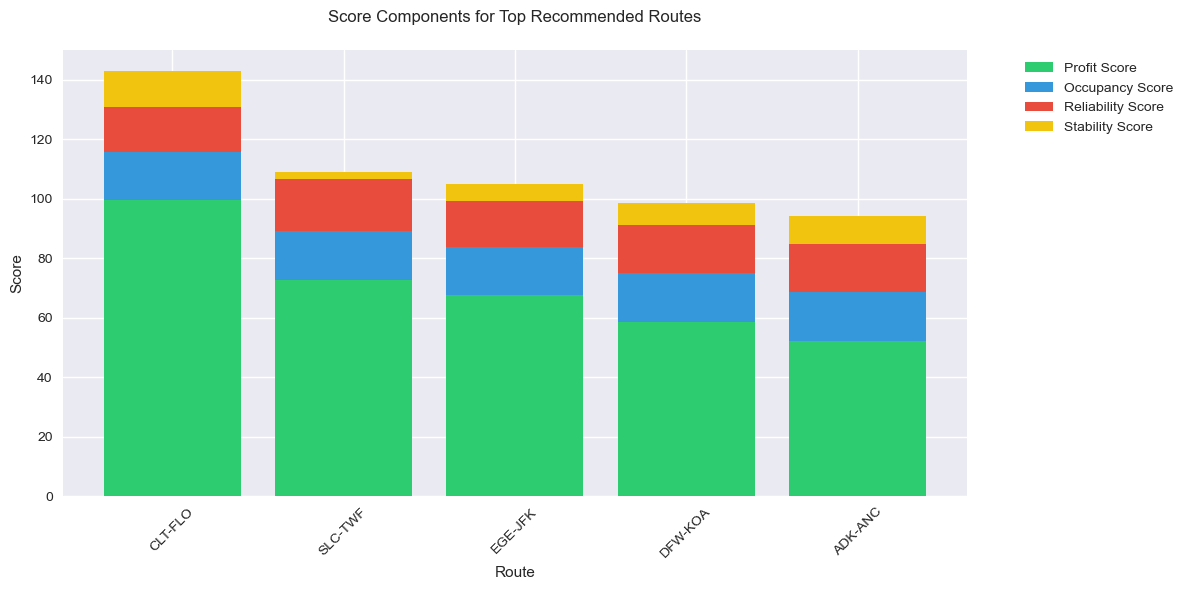

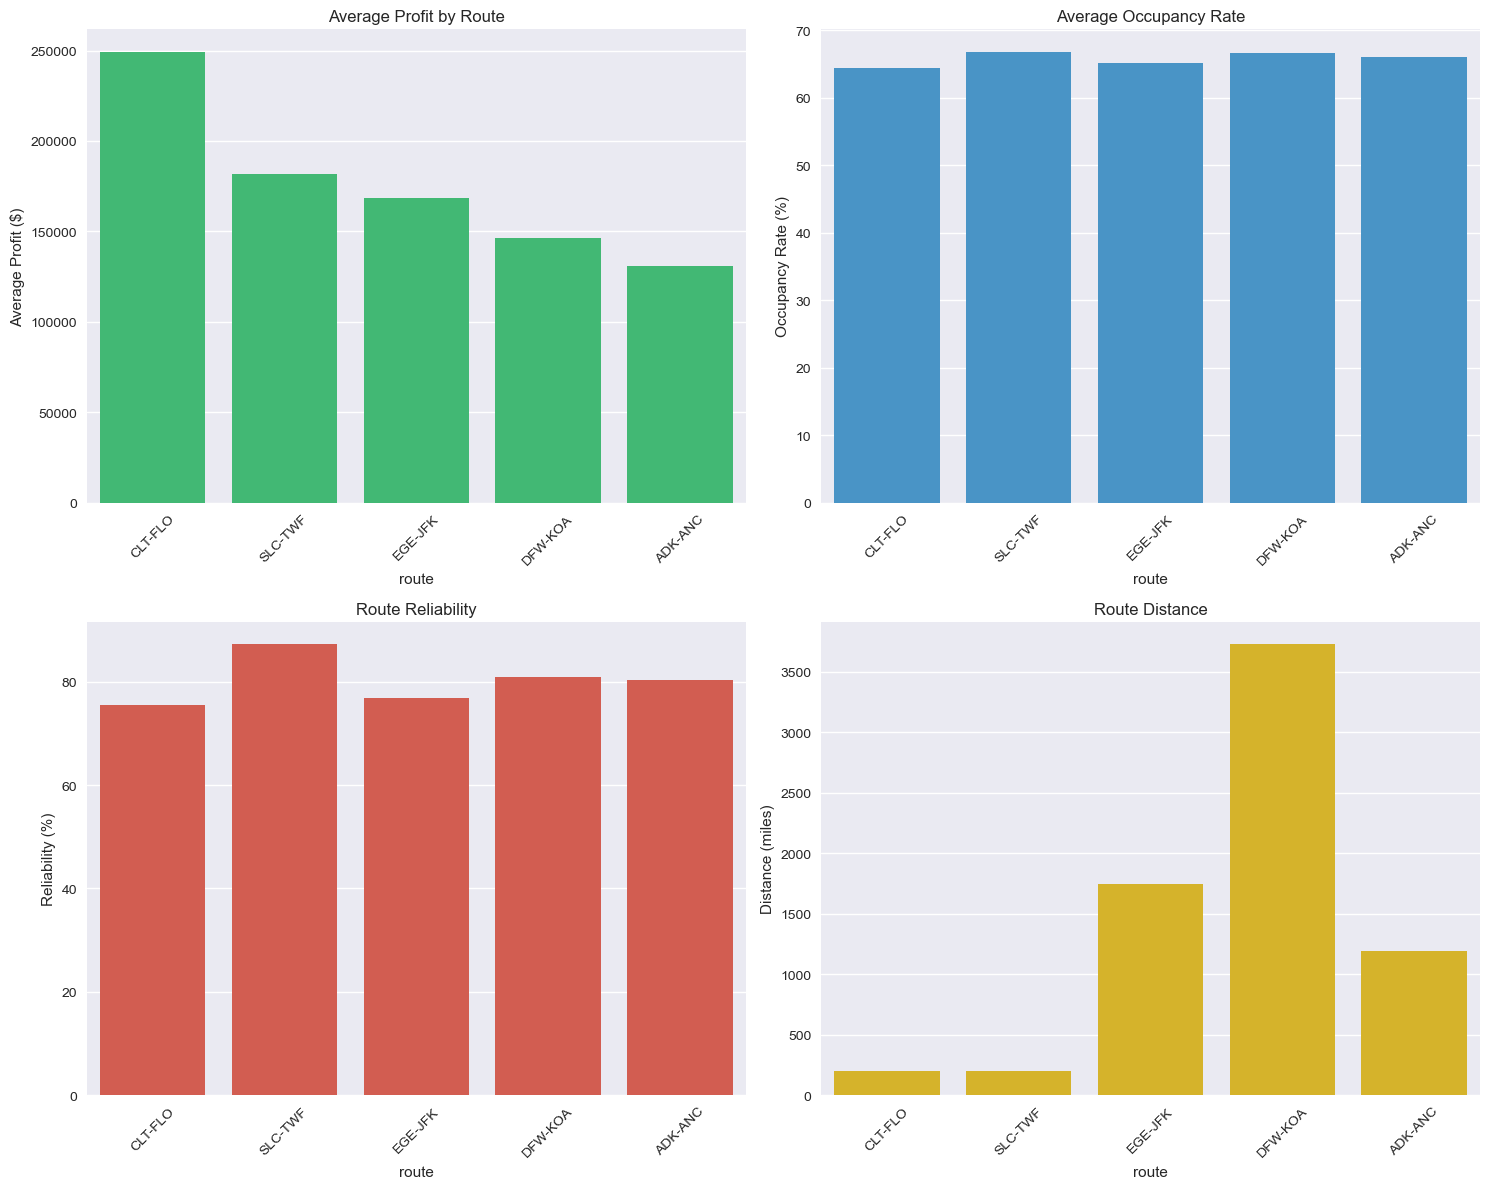


TOP 5 RECOMMENDED ROUTES

1. CLT-FLO
   Distance: 200 miles
   Average Profit: $249,207.73
   Occupancy Rate: 64.4%
   Reliability: 75.6%

   Score Breakdown:
   - Profit Score: 99.7
   - Occupancy Score: 16.1
   - Reliability Score: 15.1
   - Stability Score: 12.0
   = Total Score: 142.9

   Breakeven Analysis:
   - Breakeven Flights: 361
   - Days to Breakeven: 181
   - Years to Breakeven: 0.5

2. SLC-TWF
   Distance: 200 miles
   Average Profit: $181,535.82
   Occupancy Rate: 66.8%
   Reliability: 87.2%

   Score Breakdown:
   - Profit Score: 72.6
   - Occupancy Score: 16.7
   - Reliability Score: 17.4
   - Stability Score: 2.2
   = Total Score: 109.0

   Breakeven Analysis:
   - Breakeven Flights: 496
   - Days to Breakeven: 248
   - Years to Breakeven: 0.7

3. EGE-JFK
   Distance: 1,746 miles
   Average Profit: $168,676.89
   Occupancy Rate: 65.2%
   Reliability: 76.9%

   Score Breakdown:
   - Profit Score: 67.5
   - Occupancy Score: 16.3
   - Reliability Score: 15.4
   - Stabil

In [156]:
def calculate_route_scores(airline_data: pd.DataFrame) -> pd.DataFrame:
 
    metrics = []
    
    for route, group in airline_data.groupby('ROUNDTRIP'):
       
        avg_profit = group['PROFIT'].mean()
        avg_occupancy = group['OCCUPANCY_RATE'].mean()
        total_flights = len(group)
        distance = group['DISTANCE'].iloc[0]
        
        # Reliability calculation
        on_time_flights = group[
            (group['DEP_DELAY_CATEGORY'].isin(['Early', 'On Time']))
        ].shape[0]
        reliability = (on_time_flights / total_flights) * 100
        
        # Profit stability
        profit_cv = group['PROFIT'].std() / abs(avg_profit)
        
        # Calculate component scores
        profit_score = (avg_profit / 100000) * 40  # 40% weight
        occupancy_score = (avg_occupancy / 100) * 25  # 25% weight
        reliability_score = (reliability / 100) * 20  # 20% weight
        stability_score = (1 - profit_cv) * 15  # 15% weight
        
        total_score = profit_score + occupancy_score + reliability_score + stability_score
        
        metrics.append({
            'route': route,
            'distance': distance,
            'avg_profit': avg_profit,
            'avg_occupancy': avg_occupancy,
            'reliability': reliability,
            'total_score': total_score,
            'profit_score': profit_score,
            'occupancy_score': occupancy_score,
            'reliability_score': reliability_score,
            'stability_score': stability_score,
            'total_flights': total_flights
        })
    
    return pd.DataFrame(metrics).sort_values('total_score', ascending=False)

def create_route_visualizations(metrics_df: pd.DataFrame, recommended_df: pd.DataFrame):
    """Create visualizations for route analysis"""
   
    plt.style.use('seaborn')
    
    # Figure 1: Score Components for Top Routes
    plt.figure(figsize=(12, 6))
    data = recommended_df.copy()
    
    # Creating stacked bar chart
    bottom = np.zeros(len(data))
    
    for column, color in zip(
        ['profit_score', 'occupancy_score', 'reliability_score', 'stability_score'],
        ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']
    ):
        plt.bar(data['route'], data[column], bottom=bottom, label=column.replace('_', ' ').title(), color=color)
        bottom += data[column]
    
    plt.title('Score Components for Top Recommended Routes', pad=20)
    plt.xlabel('Route')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Route Metrics Comparison
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Average Profit
    sns.barplot(data=recommended_df, x='route', y='avg_profit', ax=ax1, color='#2ecc71')
    ax1.set_title('Average Profit by Route')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_ylabel('Average Profit ($)')
    
    # Occupancy Rate
    sns.barplot(data=recommended_df, x='route', y='avg_occupancy', ax=ax2, color='#3498db')
    ax2.set_title('Average Occupancy Rate')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.set_ylabel('Occupancy Rate (%)')
    
    # Reliability
    sns.barplot(data=recommended_df, x='route', y='reliability', ax=ax3, color='#e74c3c')
    ax3.set_title('Route Reliability')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    ax3.set_ylabel('Reliability (%)')
    
    # Distance
    sns.barplot(data=recommended_df, x='route', y='distance', ax=ax4, color='#f1c40f')
    ax4.set_title('Route Distance')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
    ax4.set_ylabel('Distance (miles)')
    
    plt.tight_layout()
    plt.show()

def calculate_breakeven(recommended_df: pd.DataFrame, airplane_cost: float = 90000000) -> pd.DataFrame:
    """Calculate breakeven metrics for recommended routes"""
    breakeven_metrics = []
    
    for _, route in recommended_df.iterrows():
        avg_profit = route['avg_profit']
        breakeven_flights = airplane_cost / avg_profit
        breakeven_days = breakeven_flights / 2  # Assuming 2 flights per day
        
        breakeven_metrics.append({
            'route': route['route'],
            'avg_profit_per_flight': avg_profit,
            'breakeven_flights': breakeven_flights,
            'breakeven_days': breakeven_days,
            'breakeven_years': breakeven_days / 365
        })
    
    return pd.DataFrame(breakeven_metrics)

def print_recommendations(recommended_df: pd.DataFrame, breakeven_df: pd.DataFrame):
    """Print detailed recommendations and breakeven analysis"""
    print("\nTOP 5 RECOMMENDED ROUTES")
    print("=" * 50)
    
    for idx, (_, route) in enumerate(recommended_df.iterrows(), 1):
        breakeven = breakeven_df[breakeven_df['route'] == route['route']].iloc[0]
        
        print(f"\n{idx}. {route['route']}")
        print(f"   Distance: {route['distance']:,.0f} miles")
        print(f"   Average Profit: ${route['avg_profit']:,.2f}")
        print(f"   Occupancy Rate: {route['avg_occupancy']:.1f}%")
        print(f"   Reliability: {route['reliability']:.1f}%")
        print("\n   Score Breakdown:")
        print(f"   - Profit Score: {route['profit_score']:.1f}")
        print(f"   - Occupancy Score: {route['occupancy_score']:.1f}")
        print(f"   - Reliability Score: {route['reliability_score']:.1f}")
        print(f"   - Stability Score: {route['stability_score']:.1f}")
        print(f"   = Total Score: {route['total_score']:.1f}")
        print("\n   Breakeven Analysis:")
        print(f"   - Breakeven Flights: {breakeven['breakeven_flights']:.0f}")
        print(f"   - Days to Breakeven: {breakeven['breakeven_days']:.0f}")
        print(f"   - Years to Breakeven: {breakeven['breakeven_years']:.1f}")


route_metrics = calculate_route_scores(airline_data)
recommended_routes = route_metrics.head(5)
breakeven_metrics = calculate_breakeven(recommended_routes)

# Creating visualizations
create_route_visualizations(route_metrics, recommended_routes)

# Printing recommendations
print_recommendations(recommended_routes, breakeven_metrics)


recommended_routes_df = recommended_routes
breakeven_analysis_df = breakeven_metrics


## KPI'S

#### Financial


Financial KPIs Summary for Recommended Routes:
           RASM  CASM  PROFIT_mean  OCCUPANCY_RATE_mean
ROUNDTRIP                                              
ADK-ANC    0.64  0.09    130716.31                66.04
CLT-FLO    6.54  0.31    249207.73                64.36
DFW-KOA    0.26  0.06    146190.52                66.63
EGE-JFK    0.57  0.09    168676.89                65.21
SLC-TWF    4.85  0.32    181535.82                66.80


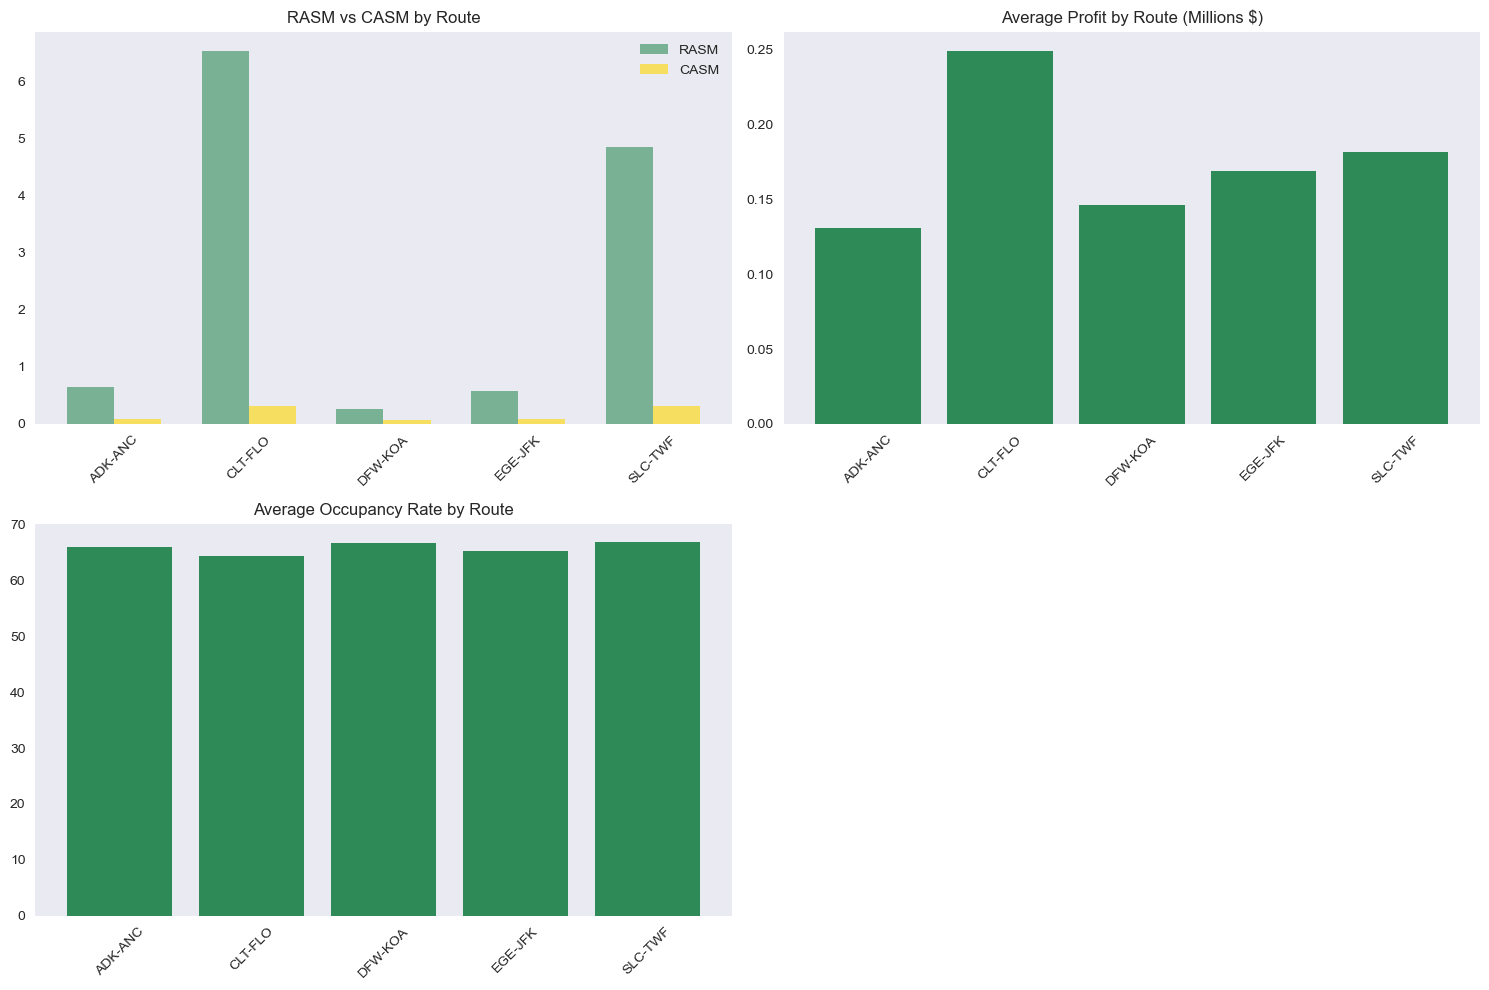

In [157]:
# 1. Financial Performance KPIs
def calculate_financial_kpis(airline_data, recommended_routes=['CLT-FLO', 'SLC-TWF', 'EGE-JFK', 'DFW-KOA', 'ADK-ANC']):
    
    # Filtering data for recommended routes first
    filtered_data = airline_data[airline_data['ROUNDTRIP'].isin(recommended_routes)]
    
    # Calculating KPIs for filtered data
    financial_kpis = filtered_data.groupby('ROUNDTRIP').agg({
        'TOTAL_REVENUE': ['mean', 'sum'],
        'TOTAL_COST': ['mean', 'sum'],
        'PROFIT': ['mean', 'sum'],
        'OCCUPANCY_RATE': 'mean',
        'DISTANCE': 'first'
    }).round(2)
    
   
    financial_kpis.columns = ['_'.join(col).strip() for col in financial_kpis.columns.values]
    
    # Calculate RASM and CASM
    financial_kpis['RASM'] = financial_kpis['TOTAL_REVENUE_mean'] / (financial_kpis['DISTANCE_first'] * 200)
    financial_kpis['CASM'] = financial_kpis['TOTAL_COST_mean'] / (financial_kpis['DISTANCE_first'] * 200)
    
    
    print("\nFinancial KPIs Summary for Recommended Routes:")
    print("=" * 50)
    print(financial_kpis[['RASM', 'CASM', 'PROFIT_mean', 'OCCUPANCY_RATE_mean']].round(2))
    
    return financial_kpis

def plot_financial_kpis(financial_kpis):
    """Create visualizations for financial KPIs of specific routes"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.patch.set_facecolor('white')
    
    # Plot 1: RASM vs CASM
    ax1 = axes[0,0]
    x = range(len(financial_kpis.index))
    width = 0.35
    ax1.bar([i - width/2 for i in x], financial_kpis['RASM'], 
            width, label='RASM', color='seagreen', alpha=0.6)
    ax1.bar([i + width/2 for i in x], financial_kpis['CASM'], 
            width, label='CASM', color='gold', alpha=0.6)
    ax1.set_title('RASM vs CASM by Route')
    ax1.set_xticks(x)
    ax1.set_xticklabels(financial_kpis.index, rotation=45)
    ax1.legend()
    ax1.grid(False)
    
    # Plot 2: Average Profit
    ax2 = axes[0,1]
    ax2.bar(financial_kpis.index, financial_kpis['PROFIT_mean']/1000000, color='seagreen')
    ax2.set_title('Average Profit by Route (Millions $)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(False)
    
    # Plot 3: Occupancy Rate
    ax3 = axes[1,0]
    ax3.bar(financial_kpis.index, financial_kpis['OCCUPANCY_RATE_mean'],color='seagreen')
    ax3.set_title('Average Occupancy Rate by Route')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(False)
    
    # Remove the fourth subplot
    axes[1,1].remove()
    
    plt.tight_layout()
    plt.show()

# Running the analysis for specific routes
recommended_routes = ['CLT-FLO', 'SLC-TWF', 'EGE-JFK', 'DFW-KOA', 'ADK-ANC']
financial = calculate_financial_kpis(airline_data, recommended_routes)

plot_financial_kpis(financial)


### Operational KPIS


Operational KPIs Summary for Recommended Routes:
           OTP_Departure_%  OTP_Arrival_%  Avg_Dep_Delay  Avg_Arr_Delay
ROUNDTRIP                                                              
ADK-ANC              13.04           4.35          -0.54         -12.54
CLT-FLO              15.56          17.78           5.64           2.60
DFW-KOA              34.83          14.61          11.21          -2.61
EGE-JFK              20.66          28.10          27.41          34.51
SLC-TWF              20.56          17.78           4.42          -0.68


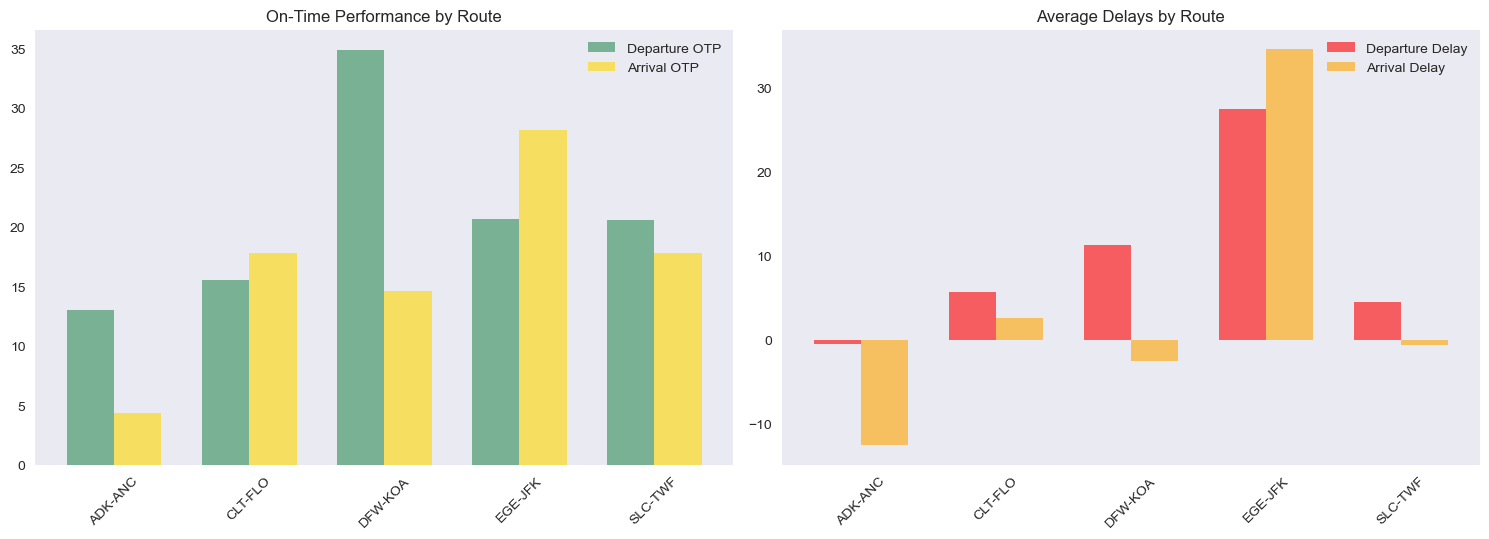

In [158]:
def calculate_operational_kpis(airline_data, recommended_routes=['CLT-FLO', 'SLC-TWF', 'EGE-JFK', 'DFW-KOA', 'ADK-ANC']):
    
    # Filtering data for recommended routes first
    filtered_data = airline_data[airline_data['ROUNDTRIP'].isin(recommended_routes)]
    
    # Calculating KPIs for filtered data
    operational_kpis = filtered_data.groupby('ROUNDTRIP').agg({
        'DEP_DELAY_CATEGORY': lambda x: (x == 'On Time').mean() * 100,  # On-time departure %
        'ARR_DELAY_CATEGORY': lambda x: (x == 'On Time').mean() * 100,  # On-time arrival %
        'AVG_DEP_DELAY': 'mean',
        'AVG_ARR_DELAY': 'mean'
    }).round(2)
    
    # Renaming columns 
    operational_kpis.columns = ['OTP_Departure_%', 'OTP_Arrival_%', 
                               'Avg_Dep_Delay', 'Avg_Arr_Delay']
    
    
    print("\nOperational KPIs Summary for Recommended Routes:")
    print("=" * 50)
    print(operational_kpis)
    
    return operational_kpis

def plot_operational_kpis(operational_kpis):
    """Create visualizations for operational KPIs of specific routes"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.patch.set_facecolor('white')
    
    # Plot 1: On-Time Performance
    ax1 = axes[0,0]
    x = range(len(operational_kpis.index))
    width = 0.35
    ax1.bar([i - width/2 for i in x], operational_kpis['OTP_Departure_%'], 
            width, label='Departure OTP', color='seagreen', alpha=0.6)
    ax1.bar([i + width/2 for i in x], operational_kpis['OTP_Arrival_%'], 
            width, label='Arrival OTP', color='gold', alpha=0.6)
    ax1.set_title('On-Time Performance by Route')
    ax1.set_xticks(x)
    ax1.set_xticklabels(operational_kpis.index, rotation=45)
    ax1.legend()
    ax1.grid(False)
    
    # Plot 2: Average Delays
    ax2 = axes[0,1]
    ax2.bar([i - width/2 for i in x], operational_kpis['Avg_Dep_Delay'], 
            width, label='Departure Delay', color='red', alpha=0.6)
    ax2.bar([i + width/2 for i in x], operational_kpis['Avg_Arr_Delay'], 
            width, label='Arrival Delay', color='orange', alpha=0.6)
    ax2.set_title('Average Delays by Route')
    ax2.set_xticks(x)
    ax2.set_xticklabels(operational_kpis.index, rotation=45)
    ax2.legend()
    ax2.grid(False)
    
    # Removing unused subplots
    axes[1,0].remove()
    axes[1,1].remove()
    
    plt.tight_layout()
    plt.show()

# Running the analysis for specific routes
recommended_routes = ['CLT-FLO', 'SLC-TWF', 'EGE-JFK', 'DFW-KOA', 'ADK-ANC']
operational = calculate_operational_kpis(airline_data, recommended_routes)


plot_operational_kpis(operational)

### Cost KPIs


Cost KPIs Summary for Recommended Routes:
           MILE_COSTS_mean  MILE_COSTS_sum  DELAY_COST_mean  DELAY_COST_sum  \
ROUNDTRIP                                                                     
ADK-ANC           10942.56       503357.76           715.76         32925.0   
CLT-FLO            1836.00       165240.00           754.67         67920.0   
DFW-KOA           34186.32      3042582.48          1384.55        123225.0   
EGE-JFK           16028.28      1939421.88          4237.81        512775.0   
SLC-TWF            1836.00       330480.00           766.17        137910.0   

           AIRPORT_FEES_mean  AIRPORT_FEES_sum  Mile_Costs_%  Delay_Costs_%  \
ROUNDTRIP                                                                     
ADK-ANC              10000.0            460000         50.52           3.30   
CLT-FLO              10000.0            900000         14.58           5.99   
DFW-KOA              10000.0            890000         75.02           3.04   
EGE-JFK 

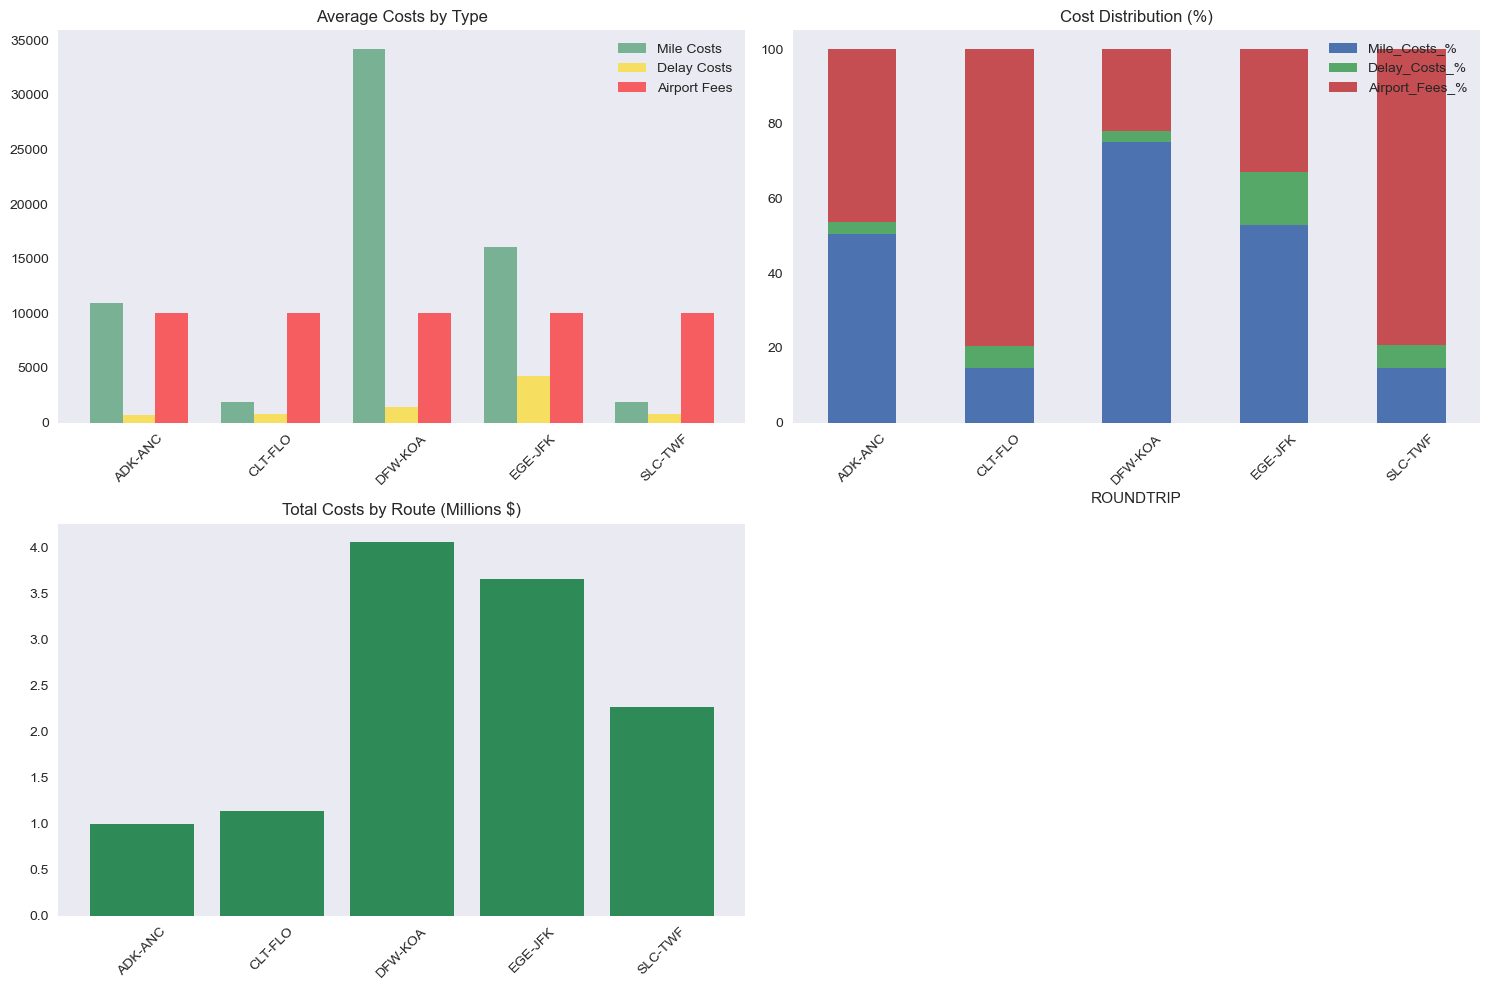

In [159]:
def calculate_cost_kpis(airline_data, recommended_routes=['CLT-FLO', 'SLC-TWF', 'EGE-JFK', 'DFW-KOA', 'ADK-ANC']):
   
   # Filtering data for recommended routes
   filtered_data = airline_data[airline_data['ROUNDTRIP'].isin(recommended_routes)]
   
   # Calculating KPIs
   cost_kpis = filtered_data.groupby('ROUNDTRIP').agg({
       'MILE_COSTS': ['mean', 'sum'],
       'DELAY_COST': ['mean', 'sum'],
       'AIRPORT_FEES': ['mean', 'sum']
   }).round(2)
   
   
   cost_kpis.columns = ['_'.join(col).strip() for col in cost_kpis.columns.values]
   
   # Calculating total costs and percentages
   total_costs = (cost_kpis['MILE_COSTS_sum'] + 
                 cost_kpis['DELAY_COST_sum'] + 
                 cost_kpis['AIRPORT_FEES_sum'])
   
   cost_kpis['Mile_Costs_%'] = (cost_kpis['MILE_COSTS_sum'] / total_costs) * 100
   cost_kpis['Delay_Costs_%'] = (cost_kpis['DELAY_COST_sum'] / total_costs) * 100
   cost_kpis['Airport_Fees_%'] = (cost_kpis['AIRPORT_FEES_sum'] / total_costs) * 100
   
   print("\nCost KPIs Summary for Recommended Routes:")
   print("=" * 50)
   print(cost_kpis.round(2))
   
   return cost_kpis

def plot_cost_kpis(cost_kpis):
   """Create visualizations for cost KPIs of specific routes"""
   fig, axes = plt.subplots(2, 2, figsize=(15, 10))
   fig.patch.set_facecolor('white')
   
   # Plot 1: Average Costs by Type
   ax1 = axes[0,0]
   x = range(len(cost_kpis.index))
   width = 0.25
   ax1.bar([i - width for i in x], cost_kpis['MILE_COSTS_mean'], 
           width, label='Mile Costs', color='seagreen', alpha=0.6)
   ax1.bar([i for i in x], cost_kpis['DELAY_COST_mean'], 
           width, label='Delay Costs', color='gold', alpha=0.6)
   ax1.bar([i + width for i in x], cost_kpis['AIRPORT_FEES_mean'], 
           width, label='Airport Fees', color='red', alpha=0.6)
   ax1.set_title('Average Costs by Type')
   ax1.set_xticks(x)
   ax1.set_xticklabels(cost_kpis.index, rotation=45)
   ax1.legend()
   ax1.grid(False)
   
   # Plot 2: Cost Distribution (%)
   ax2 = axes[0,1]
   cost_percentages = cost_kpis[['Mile_Costs_%', 'Delay_Costs_%', 'Airport_Fees_%']]
   cost_percentages.plot(kind='bar', stacked=True, ax=ax2)
   ax2.set_title('Cost Distribution (%)')
   ax2.set_xticklabels(cost_kpis.index, rotation=45)
   ax2.grid(False)
   
   # Plot 3: Total Costs Comparison
   ax3 = axes[1,0]
   total_by_route = (cost_kpis['MILE_COSTS_sum'] + 
                    cost_kpis['DELAY_COST_sum'] + 
                    cost_kpis['AIRPORT_FEES_sum'])/1000000
   ax3.bar(cost_kpis.index, total_by_route, color='seagreen')
   ax3.set_title('Total Costs by Route (Millions $)')
   ax3.tick_params(axis='x', rotation=45)
   ax3.grid(False)
   
   # Removing unused subplot
   axes[1,1].remove()
   
   plt.tight_layout()
   plt.show()

# Running the analysis for specific routes
recommended_routes = ['CLT-FLO', 'SLC-TWF', 'EGE-JFK', 'DFW-KOA', 'ADK-ANC']
costs = calculate_cost_kpis(airline_data, recommended_routes)


plot_cost_kpis(costs)

In [160]:
airline_data.info()
#airline_data.to_csv('airline_data_final.csv', index=False)
#file_path = 'airline_data_final.csv'
#FileLink(file_path)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428379 entries, 0 to 428378
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   FL_DATE             428379 non-null  datetime64[ns]
 1   MONTH               428379 non-null  object        
 2   TYPE_ORIGIN         428379 non-null  object        
 3   ORIGIN              428379 non-null  object        
 4   DESTINATION         428379 non-null  object        
 5   ROUNDTRIP           428379 non-null  object        
 6   FLIGHTS_PER_ROUTE   428379 non-null  int64         
 7   FLIGHTS_ROUNDTRIP   428379 non-null  int64         
 8   TRIPS_PER_DAY       428379 non-null  float64       
 9   DISTANCE            428379 non-null  float64       
 10  OCCUPANCY_RATE      428379 non-null  float64       
 11  ITIN_FARE_AVG       428379 non-null  float64       
 12  TICKET_CNT          428379 non-null  int64         
 13  PASSENGER_CNT       428379 no

### Final Dataset

In [161]:
airline_data.head(10)

,FL_DATE,MONTH,TYPE_ORIGIN,ORIGIN,DESTINATION,ROUNDTRIP,FLIGHTS_PER_ROUTE,FLIGHTS_ROUNDTRIP,TRIPS_PER_DAY,DISTANCE,...,AVG_ARR_DELAY,ARR_DELAY_CATEGORY,PASSENGER_REVENUE,BAGGAGE_REVENUE,TOTAL_REVENUE,MILE_COSTS,AIRPORT_FEES,DELAY_COST,TOTAL_COST,PROFIT
0,2019-01-01,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,...,-9.0,Early,58739.52,3920.0,62659.52,6352.56,10000,0.0,16352.56,46306.96
1,2019-01-02,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,...,-2.0,Early,74473.32,4970.0,79443.32,6352.56,10000,0.0,16352.56,63090.76
2,2019-01-03,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,...,-12.0,Early,52446.00,3500.0,55946.00,6352.56,10000,0.0,16352.56,39593.44
3,2019-01-04,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,...,-15.5,Early,83913.60,5600.0,89513.60,6352.56,10000,0.0,16352.56,73161.04
4,2019-01-05,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,...,-7.0,Early,48250.32,3220.0,51470.32,6352.56,10000,0.0,16352.56,35117.76
5,2019-01-06,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,...,-19.5,Early,40907.88,2730.0,43637.88,6352.56,10000,0.0,16352.56,27285.32
6,2019-01-07,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,...,4.0,On Time,55592.76,3710.0,59302.76,6352.56,10000,0.0,16352.56,42950.20
7,2019-01-08,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,...,6.5,On Time,68179.80,4550.0,72729.80,6352.56,10000,0.0,16352.56,56377.24
8,2019-01-09,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,...,-21.5,Early,75522.24,5040.0,80562.24,6352.56,10000,0.0,16352.56,64209.68
9,2019-01-10,Jan,medium_airport,ABE,ATL,ABE-ATL,90,180,2.0,692.0,...,-24.0,Early,54543.84,3640.0,58183.84,6352.56,10000,0.0,16352.56,41831.28
